In [1]:

import os
import json


import pandas as pd
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    round,
    explode,
    avg,
    desc
)
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    IntegerType,
    DoubleType,
    BooleanType,
    ArrayType
)


In [2]:
spark = SparkSession.builder \
    .appName("TMDB Movie Analysis") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/27 09:43:34 WARN Utils: Your hostname, Patricks-bot, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/27 09:43:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/27 09:43:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
DATA_PATH = "/home/pazzoti/de-upskilling/tmdb-movie-analysis-with-pyspark/data/tmdb_movies.json"

assert os.path.exists(DATA_PATH), f"❌ File not found: {DATA_PATH}"
print("file found")



file found


In [4]:
movie_schema = StructType([
    StructField("id", IntegerType()),
    StructField("title", StringType()),
    StructField("original_language", StringType()),
    StructField("release_date", StringType()),
    StructField("runtime", IntegerType()),
    StructField("budget", DoubleType()),
    StructField("revenue", DoubleType()),
    StructField("popularity", DoubleType()),
    StructField("vote_average", DoubleType()),
    StructField("vote_count", IntegerType()),
    StructField("genres", ArrayType(
        StructType([
            StructField("id", IntegerType()),
            StructField("name", StringType())
        ])
    ))
])


In [5]:
movies_df = spark.read \
    .schema(movie_schema) \
    .option("multiLine", True) \
    .json(DATA_PATH) \
    .cache()

movies_df.printSchema()


root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- budget: double (nullable = true)
 |-- revenue: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)



In [6]:
movies_df.show(10, truncate=False)
print("Total movies:", movies_df.count())


+------+----------------------------+-----------------+------------+-------+------+-------------+----------+------------+----------+-----------------------------------------------------------------------+
|id    |title                       |original_language|release_date|runtime|budget|revenue      |popularity|vote_average|vote_count|genres                                                                 |
+------+----------------------------+-----------------+------------+-------+------+-------------+----------+------------+----------+-----------------------------------------------------------------------+
|299534|Avengers: Endgame           |en               |2019-04-24  |181    |3.56E8|2.7994391E9  |18.8902   |8.237       |27173     |[{12, Adventure}, {878, Science Fiction}, {28, Action}]                |
|19995 |Avatar                      |en               |2009-12-16  |162    |2.37E8|2.923706026E9|48.776    |7.601       |33334     |[{28, Action}, {12, Adventure}, {14, Fantasy}, {

In [7]:
movies_df = movies_df.filter(
    (col("budget") > 0) &
    (col("revenue") > 0) &
    (col("runtime").isNotNull())
)


In [8]:
movies_df = movies_df.withColumn(
    "budget_musd", round(col("budget") / 1_000_000, 2)
).withColumn(
    "revenue_musd", round(col("revenue") / 1_000_000, 2)
).withColumn(
    "profit_musd", round((col("revenue") - col("budget")) / 1_000_000, 2)
)


In [9]:
top_revenue = movies_df.select(
    "title", "revenue_musd"
).orderBy(desc("revenue_musd"))

top_revenue.show(10, truncate=False)


+----------------------------+------------+
|title                       |revenue_musd|
+----------------------------+------------+
|Avatar                      |2923.71     |
|Avengers: Endgame           |2799.44     |
|Titanic                     |2264.16     |
|Star Wars: The Force Awakens|2068.22     |
|Avengers: Infinity War      |2052.42     |
|Jurassic World              |1671.54     |
|The Lion King               |1662.02     |
|The Avengers                |1518.82     |
|Furious 7                   |1515.4      |
|Frozen II                   |1453.68     |
+----------------------------+------------+
only showing top 10 rows


In [10]:
movies_df.select(
    "title", "profit_musd"
).orderBy(desc("profit_musd")).show(10, truncate=False)


+----------------------------+-----------+
|title                       |profit_musd|
+----------------------------+-----------+
|Avatar                      |2686.71    |
|Avengers: Endgame           |2443.44    |
|Titanic                     |2064.16    |
|Star Wars: The Force Awakens|1823.22    |
|Avengers: Infinity War      |1752.42    |
|Jurassic World              |1521.54    |
|The Lion King               |1402.02    |
|Furious 7                   |1325.4     |
|Frozen II                   |1303.68    |
|The Avengers                |1298.82    |
+----------------------------+-----------+
only showing top 10 rows


In [11]:
movies_df.select(
    avg("vote_average").alias("avg_rating"),
    avg("revenue_musd").alias("avg_revenue_musd")
).show()


+-----------------+-----------------+
|       avg_rating| avg_revenue_musd|
+-----------------+-----------------+
|7.391222222222224|1691.832777777778|
+-----------------+-----------------+



In [12]:
genres_df = movies_df.select(
    "title",
    "vote_average",
    "revenue_musd",
    explode("genres").alias("genre")
)

genre_stats = genres_df.groupBy("genre.name") \
    .agg(
        avg("vote_average").alias("avg_rating"),
        avg("revenue_musd").alias("avg_revenue")
    ) \
    .orderBy(desc("avg_revenue"))

genre_stats.show(10, truncate=False)


+---------------+------------------+------------------+
|name           |avg_rating        |avg_revenue       |
+---------------+------------------+------------------+
|Drama          |7.4995            |1963.09           |
|Science Fiction|7.387600000000001 |1843.2649999999999|
|Action         |7.382833333333334 |1765.9399999999998|
|Romance        |7.4350000000000005|1765.1399999999999|
|Adventure      |7.396933333333335 |1693.8206666666665|
|Fantasy        |7.409999999999999 |1651.8480000000004|
|Crime          |7.218             |1515.4            |
|Thriller       |6.817666666666667 |1499.1366666666665|
|Comedy         |7.2               |1453.68           |
|Animation      |7.24925           |1408.2875         |
+---------------+------------------+------------------+
only showing top 10 rows


In [13]:
top_revenue_pd = top_revenue.limit(10).toPandas()


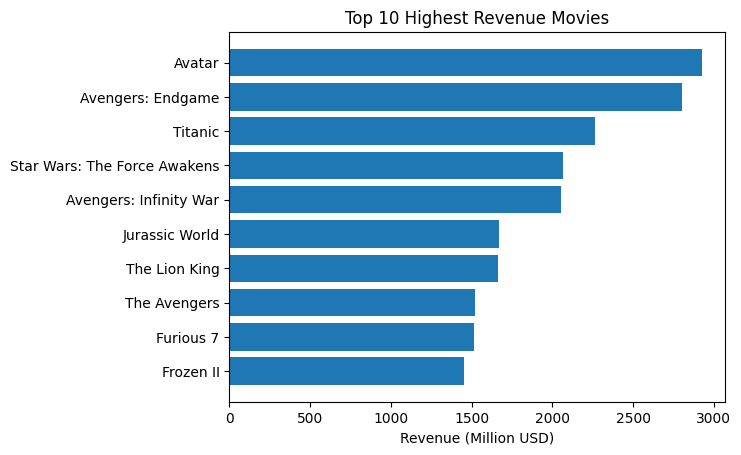

In [14]:
plt.figure()
plt.barh(top_revenue_pd["title"], top_revenue_pd["revenue_musd"])
plt.xlabel("Revenue (Million USD)")
plt.title("Top 10 Highest Revenue Movies")
plt.gca().invert_yaxis()
plt.show()


In [15]:
OUTPUT_PATH = "/home/pazzoti/de-upskilling/tmdb-movie-analysis-with-pyspark/data/movies_cleaned.parquet"

movies_df.write.mode("overwrite").parquet(OUTPUT_PATH)



In [16]:
spark.stop()
